In [ ]:
#import the needed libraries
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

## Image restoration:

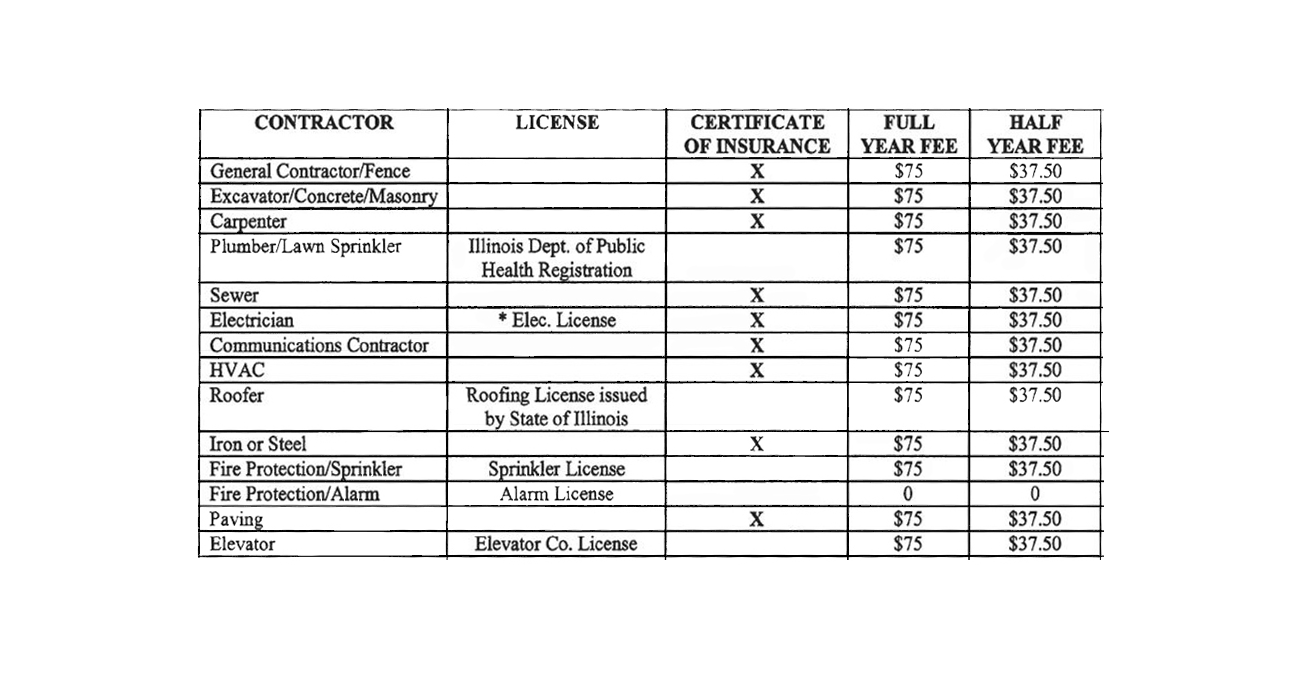

In [ ]:
import cv2
import numpy as np

#Final Algorithm with Masking applied!
def image_repair_masking(image_path, output_path):
    #Load and Convert Image
    insurance_form = cv2.imread(image_path)
    gray_insurance_form = cv2.cvtColor(insurance_form, cv2.COLOR_BGR2GRAY)

    #Preprocess the Image
    blurred = cv2.GaussianBlur(gray_insurance_form, (5, 5), 0)
    #Using an adaptive threshold yields better results in the final image
    thresh = cv2.adaptiveThreshold(gray_insurance_form, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 11, 2)

    #Edge Detection (Canny)
    edges_form = cv2.Canny(thresh, 100, 200)

    #Line Detection
    lines = cv2.HoughLines(edges_form, 1, np.pi / 180, 200)

    #Compute the rotation angle from detected lines
    angles = [np.rad2deg(line[0][1]) - 90 for line in lines]
    rotation_angle = np.median(angles)

    #Rotate the image
    (h, w) = thresh.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    rotated = cv2.warpAffine(thresh, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    rotated_original = cv2.warpAffine(gray_insurance_form, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    #Repair Broken Lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))

    horizontal_lines = cv2.morphologyEx(rotated, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    horizontal_lines = cv2.dilate(horizontal_lines, horizontal_kernel, iterations=5)

    vertical_lines = cv2.morphologyEx(rotated, cv2.MORPH_OPEN, vertical_kernel, iterations=1)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=5)

    #Combine repaired horizontal and vertical lines
    repaired_lines = cv2.add(horizontal_lines, vertical_lines)

    #Lets mask the lines
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 100))  # Adjust size depending on the gaps
    closed_image = cv2.morphologyEx(rotated, cv2.MORPH_CLOSE, kernel)

    #Find the contours
    contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #Crating a new mask
    mask = np.zeros_like(rotated, dtype=np.uint8)

    #Draw filled contours on the mask
    final = cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)  # Filling the contours

    #Combine the lines with the mask
    finished_lines = cv2.bitwise_and(repaired_lines, repaired_lines, mask = final)
    #Convert the binary image
    inverted_finished_lines = cv2.bitwise_not(finished_lines)
    #Combine the lines with our original rotated image
    final_corrected_image = cv2.bitwise_and(inverted_finished_lines, rotated_original)

    #Save and display the final result
    cv2_imshow(final_corrected_image)
    cv2.imwrite('repaired_insurance_form_masked.jpg', final_corrected_image)


#Let's run the algorithm!
image_repair_masking('/content/hw5_insurance_form.jpg', 'repaired_insurance_form_masked.jpg')

## Step by step:

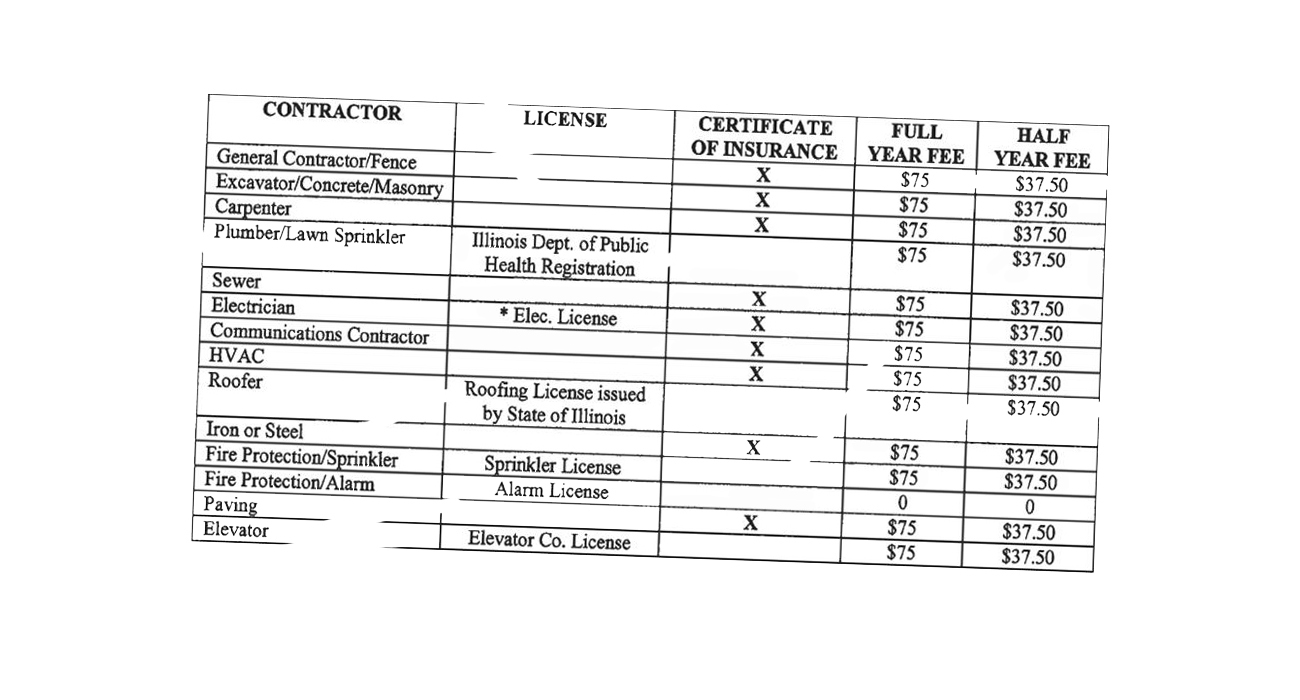

In [ ]:
#Load the image
insurance_form = cv2.imread('/content/hw5_insurance_form.jpg')

#Convert image to grayscale
gray_insurance_form = cv2.cvtColor(insurance_form, cv2.COLOR_BGR2GRAY)

#Show image
cv2_imshow(gray_insurance_form)

In [ ]:
blurred = cv2.GaussianBlur(gray_insurance_form, (5, 5), 0)

#Thresholding to binarize the image
thresh = cv2.adaptiveThreshold(gray_insurance_form, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 11, 2)

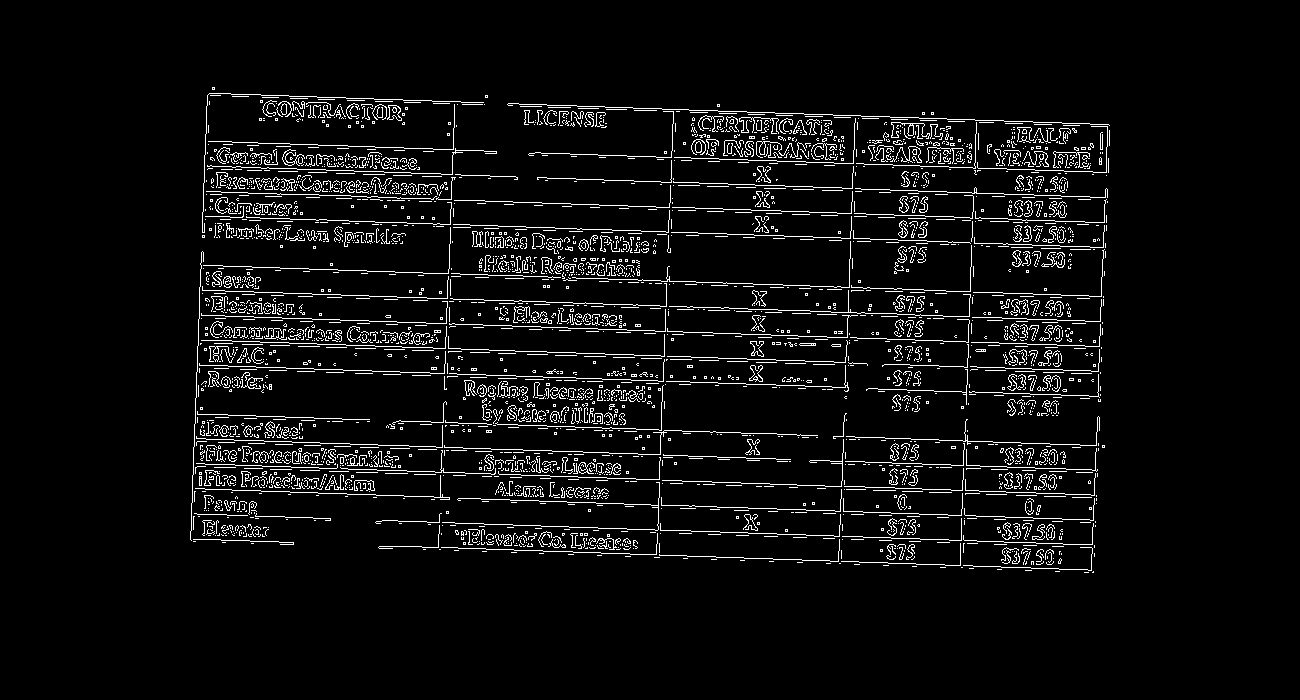

In [ ]:
#Rotating the image
#Detect the edges
edges_form = cv2.Canny(thresh, 100, 200)
#edges_form = cv2.Sobel(thresh, cv2.CV_8U, 1, 0, ksize=3)

# Detect lines using Hough Transform
lines = cv2.HoughLines(edges_form, 1, np.pi / 180, 200)

#Show edges
cv2_imshow(edges_form)

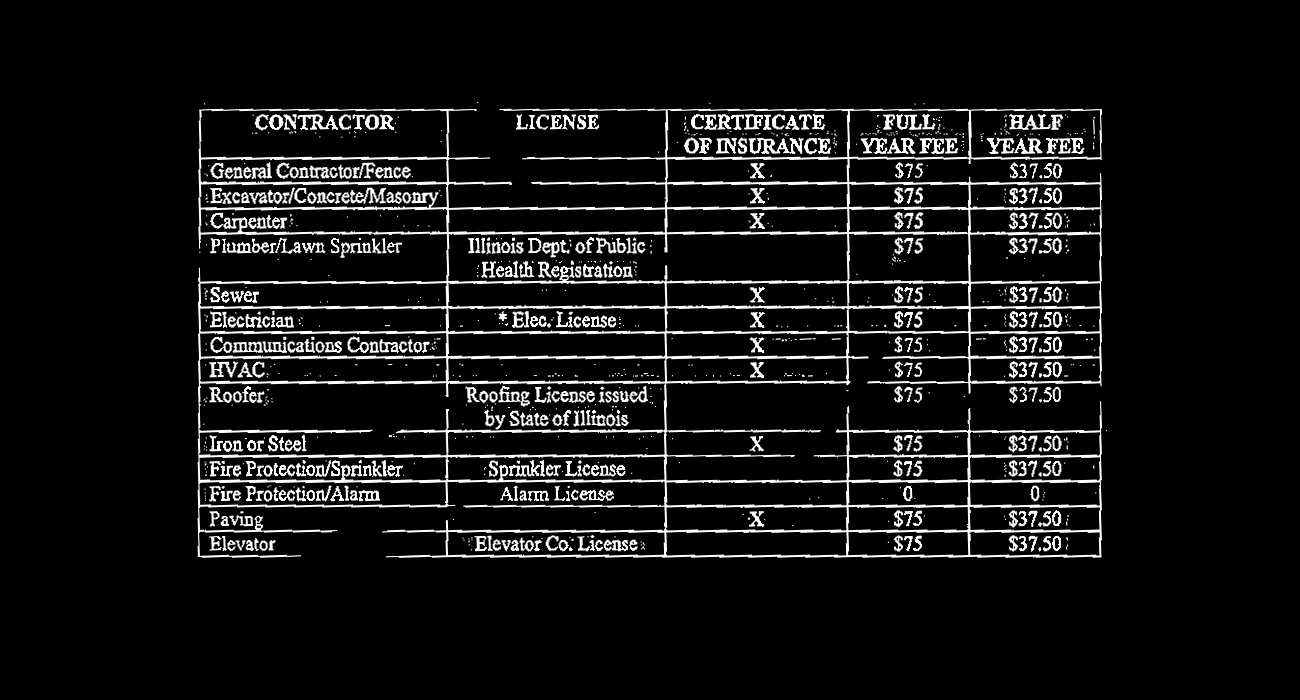

In [ ]:
# Compute the angle of rotation
angles = []
for line in lines:
    rho, theta = line[0]
    angle = np.rad2deg(theta) - 90  # Convert to degrees, -90 degrees as the image appears vertical
    angles.append(angle)

# Median angle is more robust to noise
rotation_angle = np.median(angles)

# Rotate the image
(h, w) = thresh.shape[:2]
center = (w // 2, h // 2)
rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
rotated = cv2.warpAffine(thresh, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
rotated_original = cv2.warpAffine(gray_insurance_form, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

#Show rotated image
cv2_imshow(rotated)

Reference: https://stackoverflow.com/questions/71902322/complete-missing-lines-in-table-opencv

In [ ]:
#Repair the gaps in the broken lines
#Extract horizontal and vertical lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))

#Detect and repair horizontal lines
horizontal_lines = cv2.morphologyEx(rotated, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
horizontal_lines = cv2.dilate(horizontal_lines, horizontal_kernel, iterations=20)

#Detect and repair vertical lines
vertical_lines = cv2.morphologyEx(rotated, cv2.MORPH_OPEN, vertical_kernel, iterations=1)
vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=20)

#Combine horizontal and vertical lines
repaired_lines = cv2.add(horizontal_lines, vertical_lines)

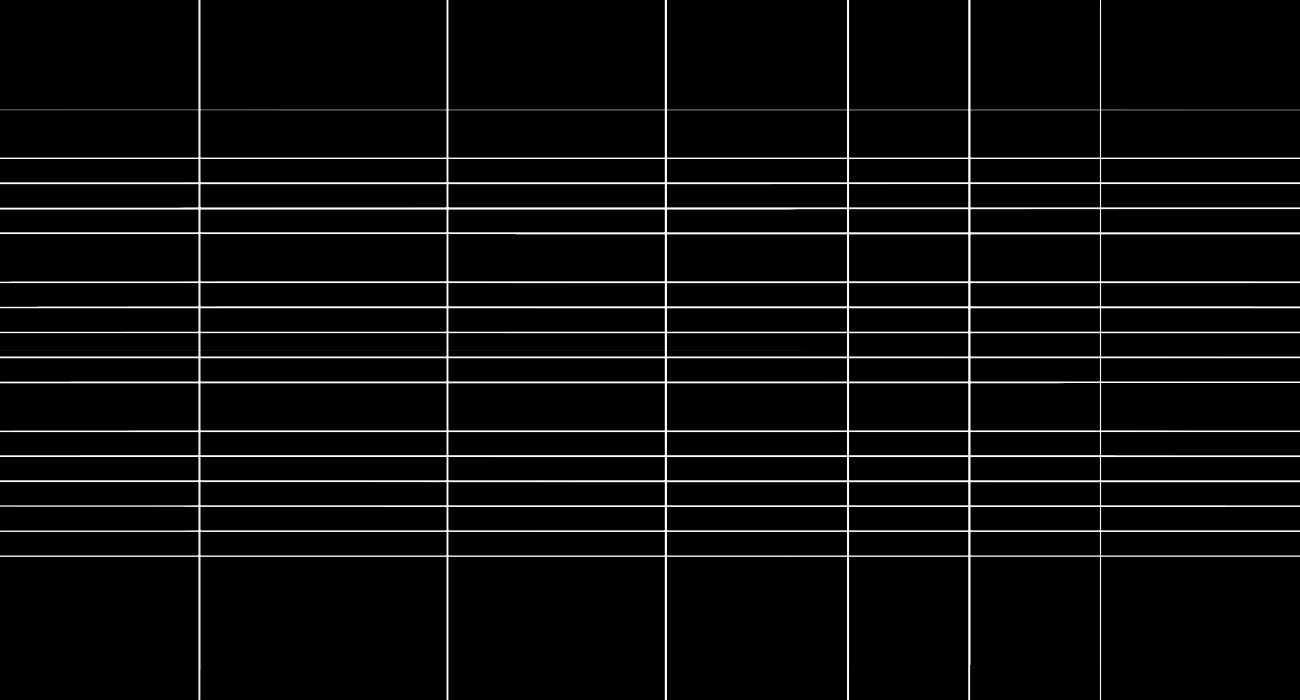

In [ ]:
#Show the lines
cv2_imshow(repaired_lines)

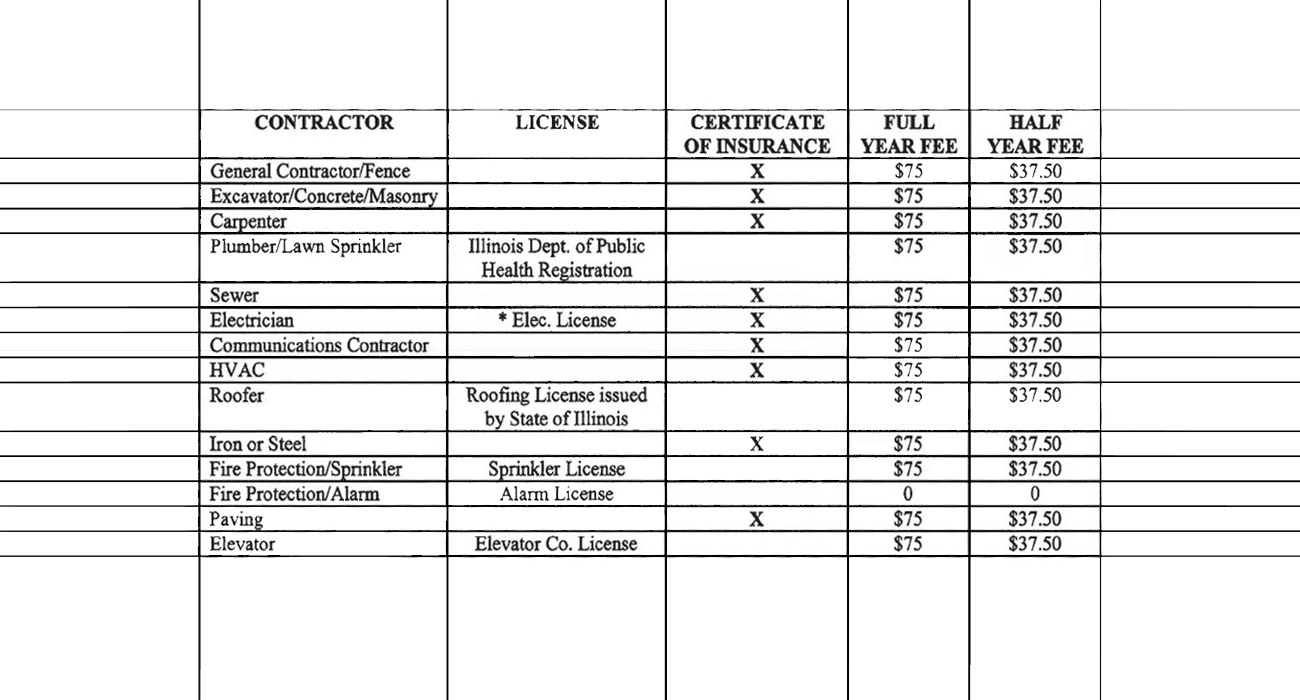

In [ ]:
#Combine the original image with the repaired lines
inverted_image = cv2.bitwise_not(repaired_lines) #Inverting the image from binary
image_lines = cv2.bitwise_and(inverted_image, rotated_original)

#Show the repaired image
cv2_imshow(image_lines)

In [ ]:
#Save the final Image
cv2.imwrite('repaired_insurance_form.jpg', image_lines)

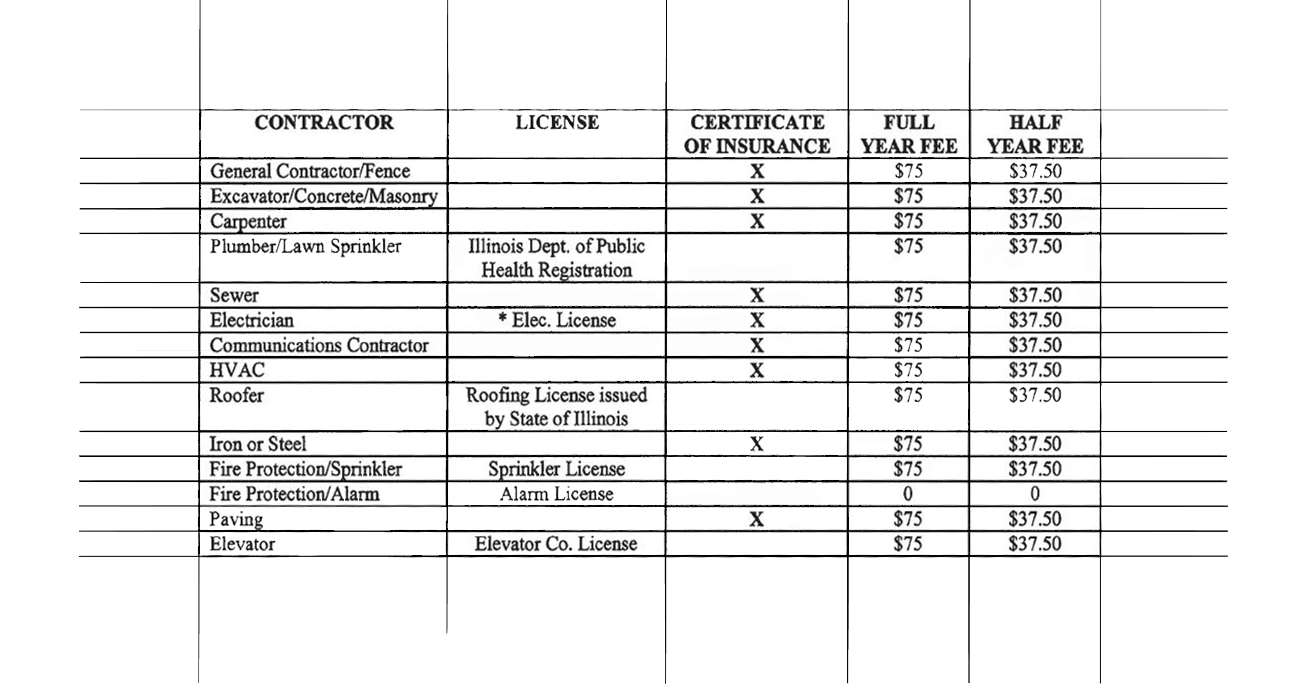

In [ ]:
#Final algorith for rotating and repairing lines of the image
import cv2
import numpy as np

def repair_image(image_path, output_path):
    #Load and Convert Image
    insurance_form = cv2.imread(image_path)
    gray_insurance_form = cv2.cvtColor(insurance_form, cv2.COLOR_BGR2GRAY)

    #Preprocess the Image
    blurred = cv2.GaussianBlur(gray_insurance_form, (5, 5), 0)
    #Using an adaptive threshold yields better results in the final image
    thresh = cv2.adaptiveThreshold(gray_insurance_form, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 11, 2)

    #Edge Detection (Canny)
    edges_form = cv2.Canny(thresh, 100, 200)

    #Line Detection
    lines = cv2.HoughLines(edges_form, 1, np.pi / 180, 200)

    #Compute the rotation angle from detected lines
    angles = [np.rad2deg(line[0][1]) - 90 for line in lines]
    rotation_angle = np.median(angles)

    #Rotate the image
    (h, w) = thresh.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
    rotated = cv2.warpAffine(thresh, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    rotated_original = cv2.warpAffine(gray_insurance_form, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    #Repair Broken Lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))

    horizontal_lines = cv2.morphologyEx(rotated, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    horizontal_lines = cv2.dilate(horizontal_lines, horizontal_kernel, iterations=5)

    vertical_lines = cv2.morphologyEx(rotated, cv2.MORPH_OPEN, vertical_kernel, iterations=1)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=5)

    #Combine repaired horizontal and vertical lines
    repaired_lines = cv2.add(horizontal_lines, vertical_lines)

    #Combine the repaired lines with the original image
    inverted_image = cv2.bitwise_not(repaired_lines)
    image_lines = cv2.bitwise_and(inverted_image, rotated_original)

    #Save and display the final result
    cv2_imshow(image_lines)
    cv2.imwrite('repaired_insurance_form.jpg', image_lines)


#Let's run the algorith!
repair_image('/content/hw5_insurance_form.jpg', 'repaired_insurance_form.jpg')

The lines have been repaired.
These appear longer than in the original image. In the next steps I attempted making a mask to erase the excess lines.

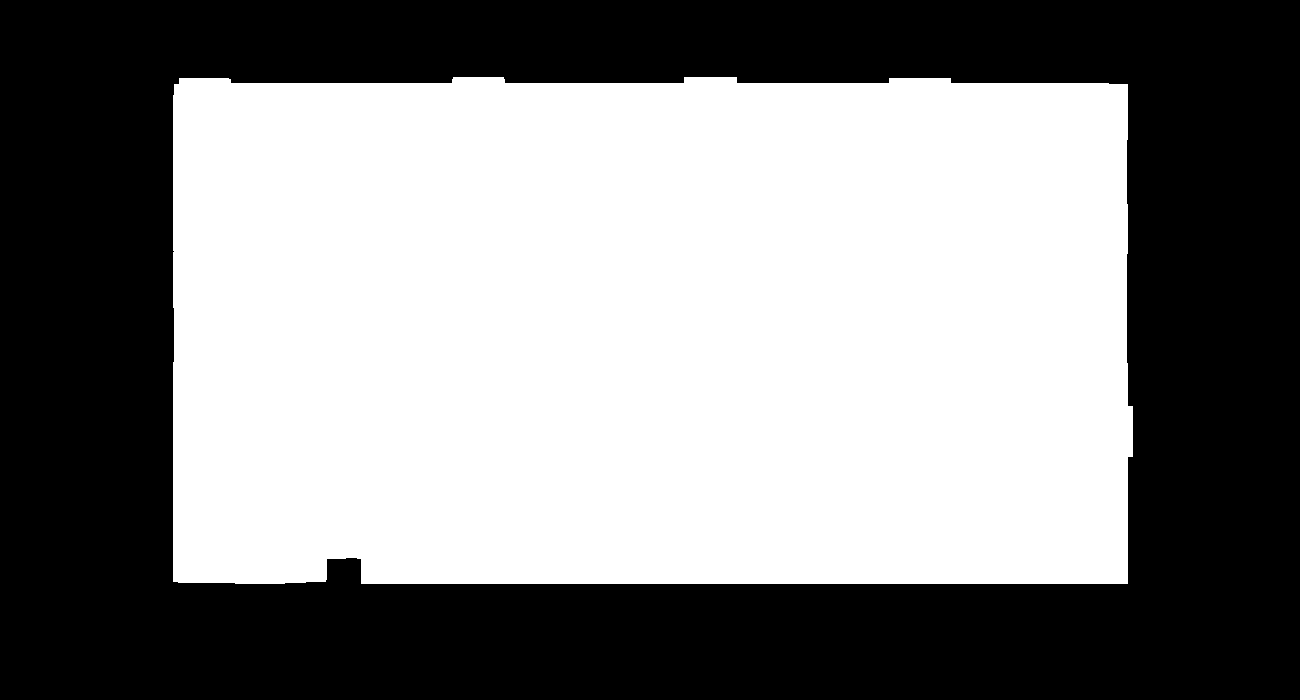

In [ ]:
#Creating a mask to reduce the out of bounds lines (Utilizing the code from the reference)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50,50))
dilate = cv2.dilate(rotated, kernel, iterations=1)

contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key = cv2.contourArea)           # contour with largest area
black = np.zeros_like(rotated, dtype=np.uint8)
mask = cv2.drawContours(black, [max_contour], -1, 255, thickness=cv2.FILLED)    # --> -1 to fill the contour

cv2_imshow(mask)

Not the best method to create a mask in this case. The mask doesn't fill in the gaps correctly. A different method has to be done.

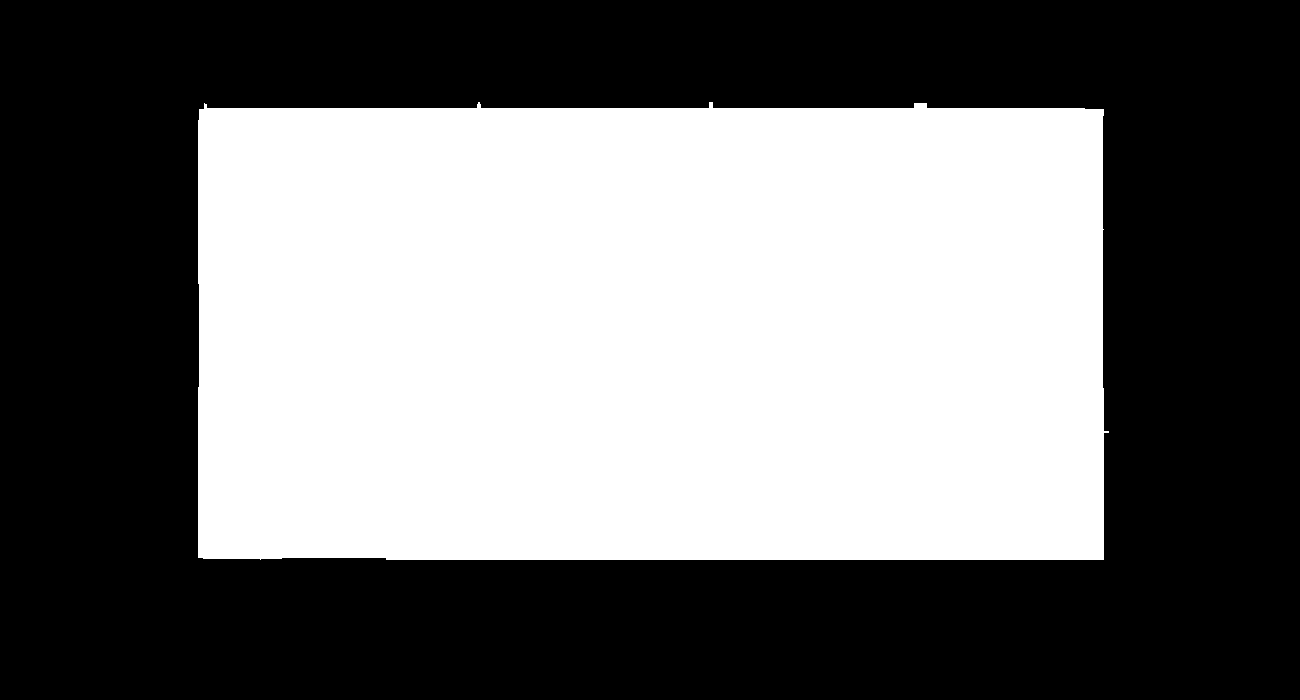

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (100, 100))  #Adjusting the size depending on the gaps
closed_image = cv2.morphologyEx(rotated, cv2.MORPH_CLOSE, kernel)

#Find contours in the binary image
contours, _ = cv2.findContours(closed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#Create an empty mask (same size as the input image)
mask = np.zeros_like(rotated, dtype=np.uint8)

#Draw filled contours on the mask
final = cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)

cv2_imshow(final)

A better approach of creating a mask for this case. Given the high kernel value, I have my doubts on how this method would work with a different image. None the less we have a better result at the end.

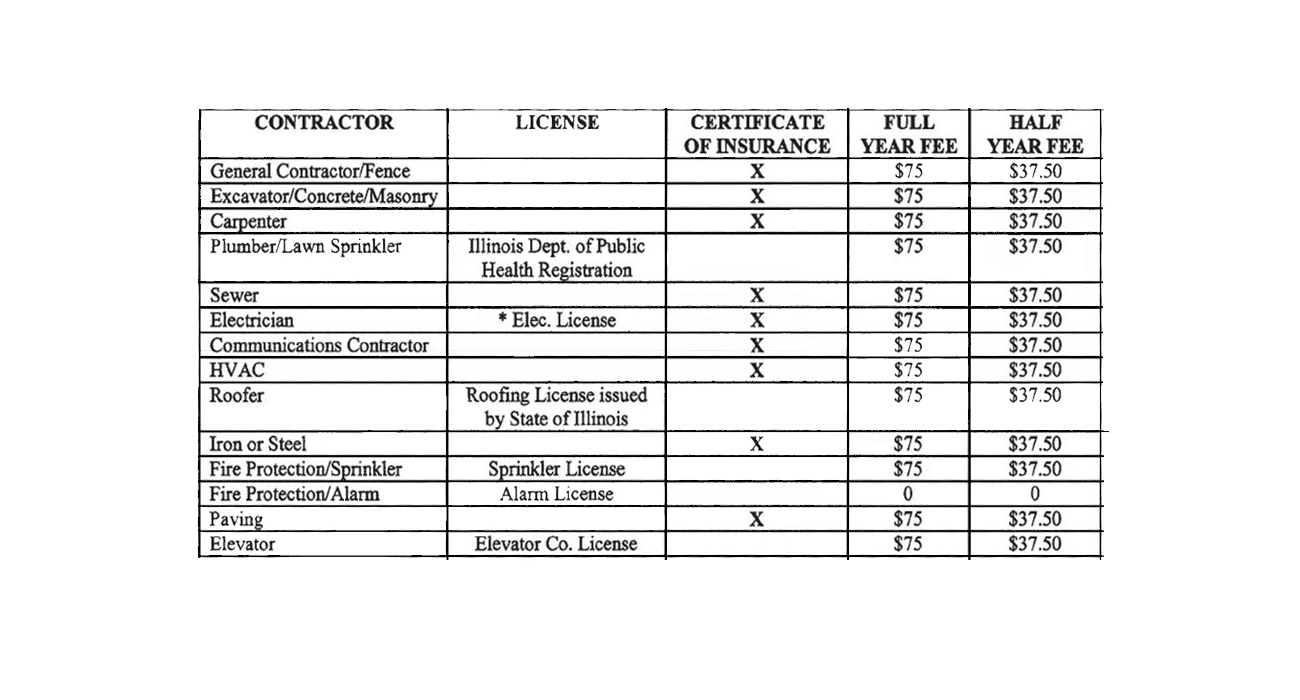

In [ ]:
#Combine the lines with the mask
finished_lines = cv2.bitwise_and(repaired_lines, repaired_lines, mask = final)
#Invert the binary
inverted_finished_lines = cv2.bitwise_not(finished_lines)
#Combine the lines with the original rotated image
final_corrected_image = cv2.bitwise_and(inverted_finished_lines, rotated_original)
cv2_imshow(final_corrected_image)